Kaggle Competition

https://www.kaggle.com/competitions/playground-series-s5e7/code

Predict the Introverts from the Extroverts


### Data Exploration

In [4]:
import pandas as pd

# Load data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Preview the first few rows
train.head()



,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Show columns and data types
train.info()


Train shape: (18524, 9)
Test shape: (6175, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [6]:
# Check missing values
train.isnull().sum()

# Check class balance
train['Personality'].value_counts(normalize=True)


Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64

In [7]:
train.describe()


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


- Some rows have missing values (e.g. Drained_after_socializing)

- But other columns with correlated behavioral meaning (like Social_event_attendance) might help us guess those missing values

- That’s a pattern we can exploited — pairing up known values to predict/restore unknowns

`Social_event_attendance` = 1 -> very low

`Drained_after_socializing` = `NaN`, but based on others like them, maybe “Yes”?

**Group by known values**

In [8]:
# Let's look at the average attendance for people who are drained
train.groupby('Drained_after_socializing')['Social_event_attendance'].mean()

Drained_after_socializing
No     6.473379
Yes    1.644860
Name: Social_event_attendance, dtype: float64

**Then reverse it: look at drained rates for different attendance levels**

In [9]:
# Binned social event attendance vs drain rate
pd.crosstab(
    pd.cut(train['Social_event_attendance'], bins=[0,2,5,10]),
    train['Drained_after_socializing'],
    normalize='index'
)

Drained_after_socializing,No,Yes
Social_event_attendance,,
"(0, 2]",0.011587,0.988413
"(2, 5]",0.806196,0.193804
"(5, 10]",0.997683,0.002317


**What we learned**

- If someone goes out < 2 times, they are almost always drained after.

- If they go out > 5 times, they are almost never drained.

### Let’s Build a Rule

```python
# Rule-based imputation for Drained_after_socializing
train.loc[
    (train['Drained_after_socializing'].isna()) &
    (train['Social_event_attendance'] <= 2),
    'Drained_after_socializing'
] = 'Yes'

train.loc[
    (train['Drained_after_socializing'].isna()) &
    (train['Social_event_attendance'] > 5),
    'Drained_after_socializing'
] = 'No'

```

- We'll implement that or something like it when we clean the data. 

Let's continue and see what else we can find in the data.



In [10]:
# Show missing value counts and % for each column
missing_info = train.isnull().sum().to_frame(name='Missing Count')
missing_info['% Missing'] = (missing_info['Missing Count'] / len(train)) * 100
missing_info = missing_info[missing_info['Missing Count'] > 0]
missing_info.sort_values('% Missing', ascending=False)

,Missing Count,% Missing
Stage_fear,1893,10.219175
Going_outside,1466,7.914057
Post_frequency,1264,6.823580
Time_spent_Alone,1190,6.424098
Social_event_attendance,1180,6.370114
Drained_after_socializing,1149,6.202764
Friends_circle_size,1054,5.689916


In [11]:
# Compare average social engagement of people with/without stage fear
pd.crosstab(train['Stage_fear'], train['Social_event_attendance'], normalize='index')


Social_event_attendance,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Stage_fear,,,,,,,,,,,
No,0.00084,0.000504,0.000840,0.045218,0.153219,0.150361,0.151958,0.153891,0.149521,0.155488,0.038158
Yes,0.23758,0.230919,0.243131,0.262559,0.013877,0.006106,0.001110,0.001943,0.000555,0.002220,0.000000


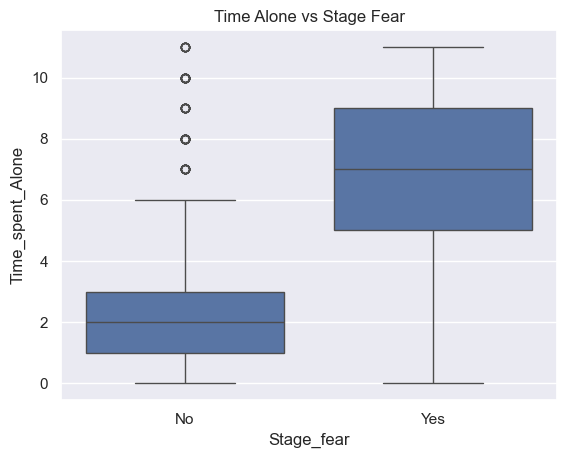

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# set a consistent style
sns.set_theme(style="darkgrid")


# Boxplot of time alone by stage fear
sns.boxplot(data=train, x='Stage_fear', y='Time_spent_Alone')
plt.title("Time Alone vs Stage Fear")
plt.show()


**Boxplot: Time_spent_Alone vs Stage_fear**

- People with Stage Fear = Yes spend a lot more time alone.

- People with Stage Fear = No cluster much lower.

Strong positive correlation between Stage_fear == Yes and Time_spent_Alone.

**Crosstab: `Stage_fear` vs `Social_event_attendance`**
|Attendance Level|Stage Fear = No|	Stage Fear = Yes|
|--|--|--|
|0–3 events|near 0%|> 97%|
|4–10 events|> 99%|~0–2%|

**Conclusion: `Stage_fear` is strongly recoverable**
---
**Rule:**
```
# Impute Stage_fear where missing
train.loc[
    (train['Stage_fear'].isna()) &
    (train['Time_spent_Alone'] >= 6) &
    (train['Social_event_attendance'] <= 3),
    'Stage_fear'
] = 'Yes'

train.loc[
    (train['Stage_fear'].isna()) &
    (train['Time_spent_Alone'] <= 3) &
    (train['Social_event_attendance'] >= 5),
    'Stage_fear'
] = 'No'
```
---


**What’s Next?**
I'll continue this for the next-highest missing column: `Going_outside` with 7.9% missing.

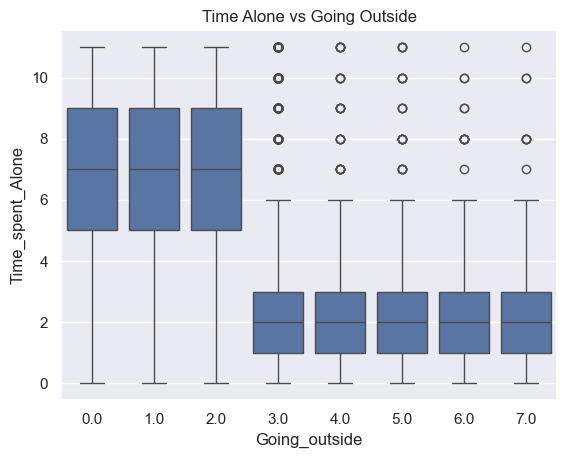

In [15]:
sns.boxplot(data=train, x='Going_outside', y='Time_spent_Alone')
plt.title("Time Alone vs Going Outside")
plt.show()

In [16]:
pd.crosstab(
    pd.cut(train['Time_spent_Alone'], bins=[0, 3, 6, 11]),
    train['Going_outside'],
    normalize='index'
)

Going_outside,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Time_spent_Alone,,,,,,,,
"(0, 3]",0.003326,0.002257,0.003207,0.183298,0.208601,0.221430,0.210620,0.167261
"(3, 6]",0.224362,0.185364,0.204622,0.126143,0.052480,0.064516,0.065479,0.077034
"(6, 11]",0.297610,0.263347,0.292430,0.120717,0.009562,0.008367,0.004781,0.003187


**Bingo**

`Going_outside` is **highly** predictable from `Time_spent_Alone`.

|`Time_spent_Alone bucket`|`Going_outside` = 0–2|`Going_outside` = 3–7|
|--|--|--|
|0–3 hours|very low (1%)|~99%|             |
|3–6 hours|~60% low values|\~40% high values|
|6–11 hours|>85% low values|almost no high|

Conclusion: `Going_outside` is predictable

---
**Rule**
Use `Time_spent_Alone` buckets to predict `Going_outside` ranges:

```python
# Simple version — impute mode value in each time-alone bin
train.loc[
    (train['Going_outside'].isna()) &
    (train['Time_spent_Alone'] >= 6),
    'Going_outside'
] = 1  # low range

train.loc[
    (train['Going_outside'].isna()) &
    (train['Time_spent_Alone'] <= 3),
    'Going_outside'
] = 5  # high range
```

---

**Next:**
`Post_frequency` is missing ~6.8%.

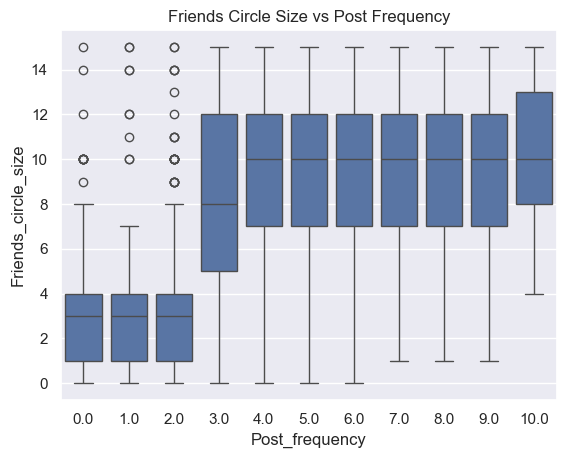

In [17]:
# How does posting frequency relate to friends_circle_size?
sns.boxplot(data=train, x='Post_frequency', y='Friends_circle_size')
plt.title("Friends Circle Size vs Post Frequency")
plt.show()

In [18]:
pd.crosstab(
    pd.cut(train['Friends_circle_size'], bins=[0, 5, 10, 15]),
    train['Post_frequency'],
    normalize='index'
)


Post_frequency,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Friends_circle_size,,,,,,,,,,,
"(0, 5]",0.207016,0.195391,0.205792,0.128493,0.041403,0.044259,0.043647,0.042627,0.038344,0.045482,0.007546
"(5, 10]",0.005256,0.002718,0.007611,0.130482,0.127764,0.134469,0.130482,0.141718,0.135556,0.129395,0.054549
"(10, 15]",0.000554,0.001294,0.001848,0.137313,0.128627,0.138791,0.136389,0.136204,0.131214,0.128996,0.058769


**Interpretation: `Post_frequency` vs `Friends_circle_size`**

**Boxplot:**
- Clear upward trend.

- Low Post_frequency (0–2) → low friend counts (centered around 3–4)

- High Post_frequency (5–10) → wider range, skewed up

**Crosstab Breakdown:**
|Friends Circle Size|0–2 Posts (%)|3–7 Posts (%)|8–10 Posts (%)|
|--|--|--|--|
|0–5|~61%|~30%|~9%|
|5–10|~2%|~67%|~30%|
|10–15|~0.4%|~67%|~33%|

**So:**
- Small friend circle -> very likely to post little or not at all

- Larger circles -> more likely to post frequently

- Still, some variability at the high end, social folks who don’t post

**Rule**
**Impute** `Post_frequency` from `Friends_circle_size`

I’ll bin friend circles into 3 groups and assign a default Post_frequency for each group based on median tendency:

|Friends Circle Size|Rule Bin|Default Post Freq|
|--|--|--|
|0–5|Small|**2**|
|6–10|Medium|**6**|
|11–15|Large|**8**|

---

```python
# Rule-based imputation for Post_frequency based on Friends_circle_size
small_bin = (train['Post_frequency'].isna()) & (train['Friends_circle_size'] <= 5)
medium_bin = (train['Post_frequency'].isna()) & (train['Friends_circle_size'] > 5) & (train['Friends_circle_size'] <= 10)
large_bin = (train['Post_frequency'].isna()) & (train['Friends_circle_size'] > 10)

train.loc[small_bin, 'Post_frequency'] = 2
train.loc[medium_bin, 'Post_frequency'] = 6
train.loc[large_bin, 'Post_frequency'] = 8
```

---

Things to keep in mind:

- Might want to cast back to `float` if the column’s inferred as `object` afterward.

- I’m not capturing outliers, but this rule covers maybe ~90%+ of usable imputations. **Think more on this.**


Onto:
**Missing Column: `Time_spent_Alone`**




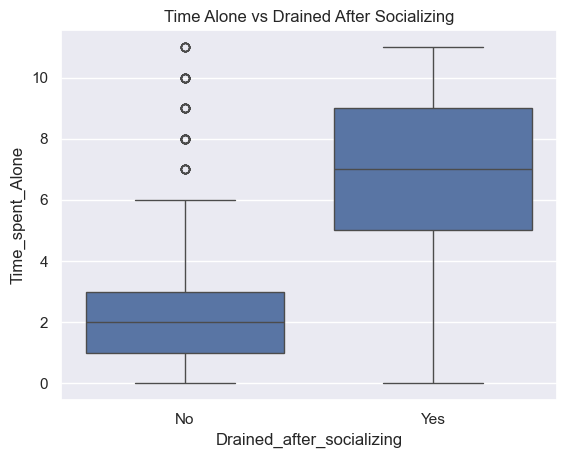

In [19]:
sns.boxplot(data=train, x='Drained_after_socializing', y='Time_spent_Alone')
plt.title("Time Alone vs Drained After Socializing")
plt.show()

In [20]:
pd.crosstab(
    train['Drained_after_socializing'],
    pd.cut(train['Time_spent_Alone'], bins=[0, 3, 6, 11]),
    normalize='index'
)

Time_spent_Alone,"(0, 3]","(3, 6]","(6, 11]"
Drained_after_socializing,,,
No,0.927971,0.065220,0.006809
Yes,0.017341,0.372307,0.610352


I'd call that a conditional distribution split.

**Rule**
**Impute `Time_spent_Alone` from `Drained_after_socializing`**

From the crosstab:

- If `Drained_after_socializing` == 'Yes' -> most people are in the 6–11 hr range.

- If 'No' -> overwhelmingly in the 0–3 hr bin.

I'll use a median-based imputation within each category:

|Drained After Socializing|Imputed `Time_spent_Alone`|
|--|--|
|Yes|**7.5**|
|No|**2.0**|

---

```python
# Impute Time_spent_Alone based on Drained_after_socializing
train.loc[(train['Time_spent_Alone'].isna()) & (train['Drained_after_socializing'] == 'Yes'), 'Time_spent_Alone'] = 7.5
train.loc[(train['Time_spent_Alone'].isna()) & (train['Drained_after_socializing'] == 'No'), 'Time_spent_Alone'] = 2.0
```
---